In [2]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "args_test" / "gpulab" / "args_test3")


# ONE TO ONE

                            Name    Args  Total relative time
2  nai_warp_per_shift_shared_mem  16_256             7.068701
0  nai_warp_per_shift_shared_mem  16_160             7.217298
1  nai_warp_per_shift_shared_mem  16_192             7.244337


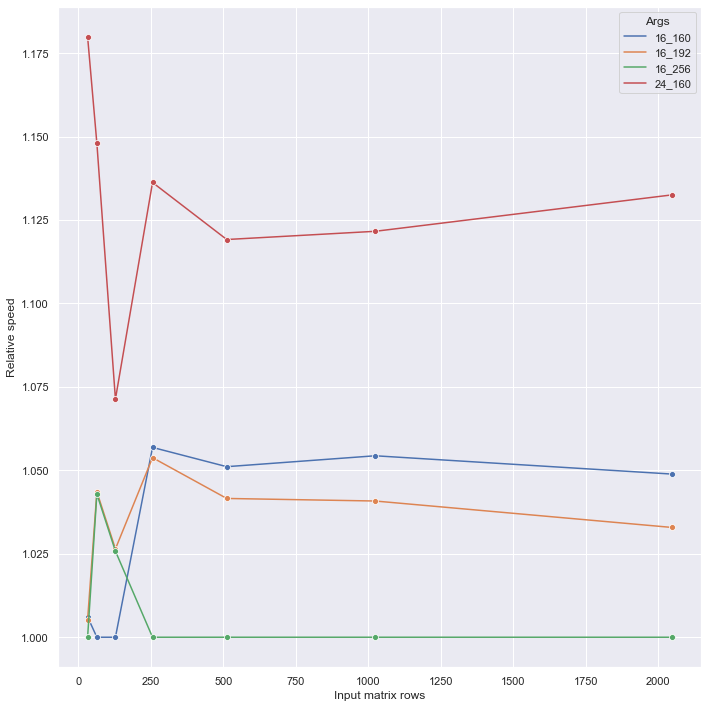

In [7]:
group = benchmark.groups["one_to_one"]

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

# data = data[data["Input matrix rows"] >= 256]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])



kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

min_times = results.groupby(["Name", "Input matrix rows"])["Kernel time"].min().to_frame("Kernel time").reset_index()


def speedup(row):
    min_time = min_times[(min_times["Name"] == row["Name"]) & (min_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return row["Kernel time"] / min_time

results["Relative speed"] = results.apply(speedup, axis=1)



sns.set(rc={'figure.figsize': (10, 10)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Relative speed", hue="Args", marker='o', ax=ax)

#ax.set_title(f"{results['Name']}")
fig.tight_layout()

best_args = results.groupby(["Name", "Args"])["Relative speed"].sum().to_frame("Total relative time").reset_index().sort_values("Total relative time")
print(best_args.groupby(["Name"]).head(3).sort_values("Name", kind="stable"))

# ONE TO MANY

                                       Name Args  Total relative time
0                nai_shuffle_multimat_right  2_2            31.285451
3                nai_shuffle_multimat_right  4_2            31.322606
2                nai_shuffle_multimat_right  2_8            31.447316
7  nai_shuffle_multirow_both_multimat_right    4            25.104453
6  nai_shuffle_multirow_both_multimat_right    2            25.294336


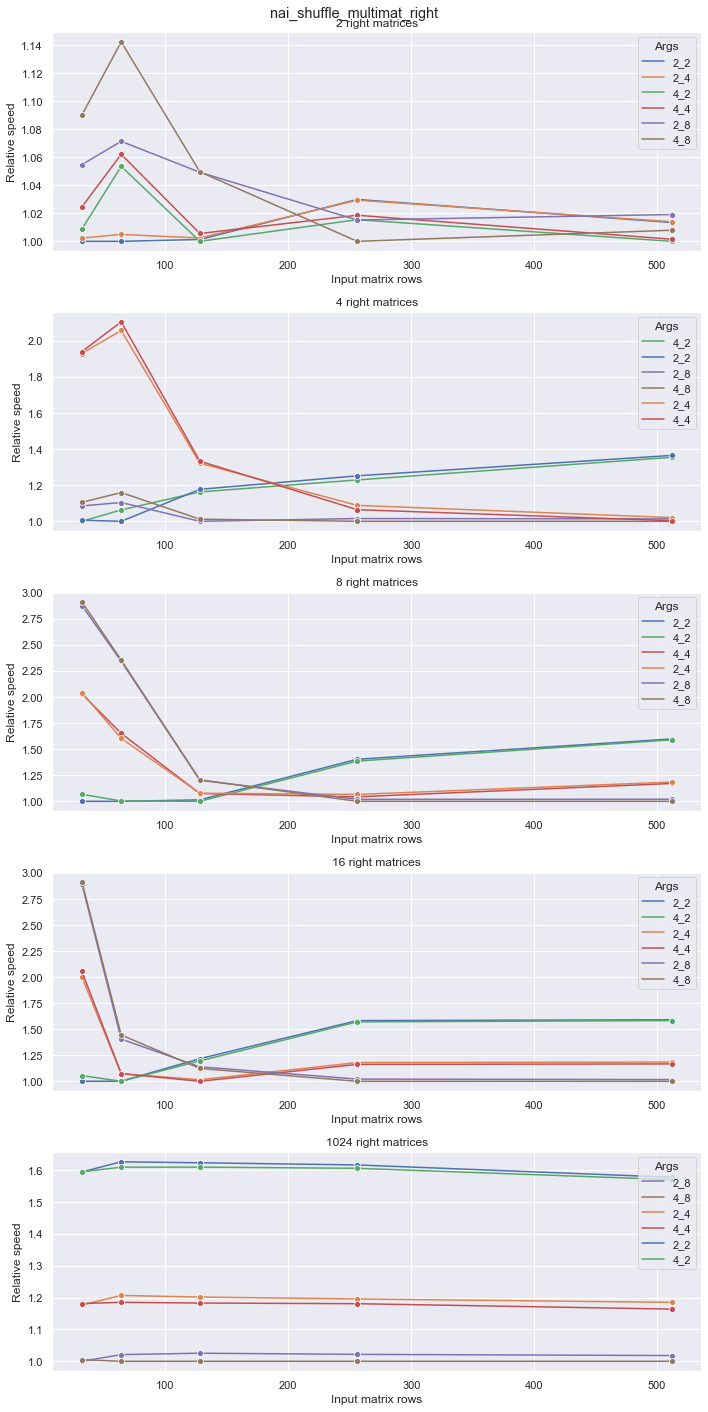

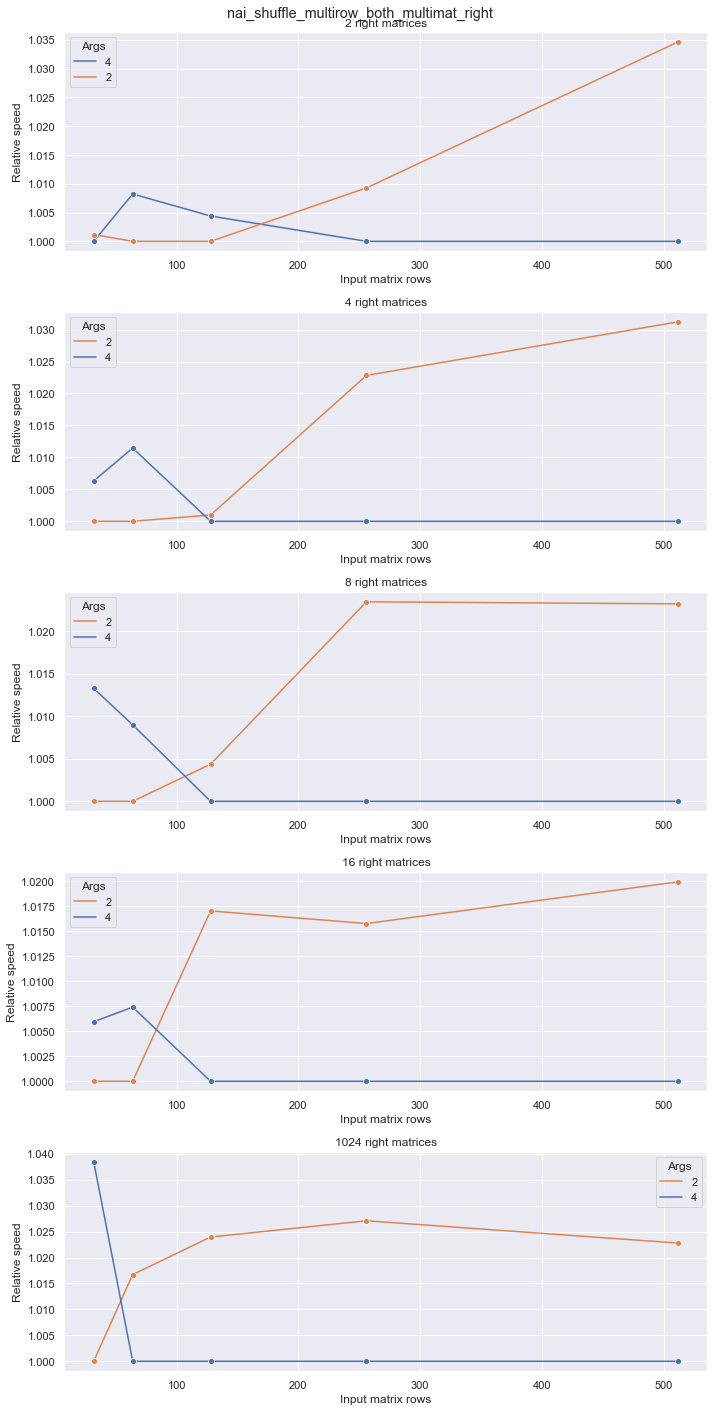

In [9]:
group = benchmark.groups["one_to_many"]

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])



kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index().sort_values("Kernel time")

min_times = results.groupby(["Name", "Input right matrices", "Input matrix rows"])["Kernel time"].min().to_frame("Kernel time").reset_index()


def speedup(row):
    min_time = min_times[(min_times["Name"] == row["Name"]) & (min_times["Input matrix rows"] == row["Input matrix rows"]) & (min_times["Input right matrices"] == row["Input right matrices"])]["Kernel time"].item()
    return row["Kernel time"] / min_time

results["Relative speed"] = results.apply(speedup, axis=1)


sns.set(rc={'figure.figsize': (10, 20)})

for name in sorted(results["Name"].unique()):

    alg_results = results[results["Name"] == name]
    fig, axs = plt.subplots(nrows=alg_results["Input right matrices"].nunique())

    palette = dict(zip(alg_results["Args"].unique(), sns.color_palette(n_colors=alg_results["Args"].nunique())))

    for idx, num_rights in enumerate(sorted(results["Input right matrices"].unique())):
        filtered_result = alg_results[alg_results["Input right matrices"] == num_rights]
        ax = sns.lineplot(data=filtered_result, x="Input matrix rows", y="Relative speed", hue="Args", marker='o', ax=axs[idx], palette=palette)

        ax.set_title(f"{num_rights} right matrices")
    fig.suptitle(f"{name}")
    fig.tight_layout()

best_args = results.groupby(["Name", "Args"])["Relative speed"].sum().to_frame("Total relative time").reset_index().sort_values("Total relative time")
print(best_args.groupby(["Name"]).head(3).sort_values("Name", kind="stable"))

# N TO MN

                                        Name Args  Total relative time
1   nai_shuffle_multirow_both_multimat_right    4            25.074569
0   nai_shuffle_multirow_both_multimat_right    2            25.320471
3  nai_shuffle_multirow_right_multimat_right    4            25.086823
2  nai_shuffle_multirow_right_multimat_right    2            25.463389


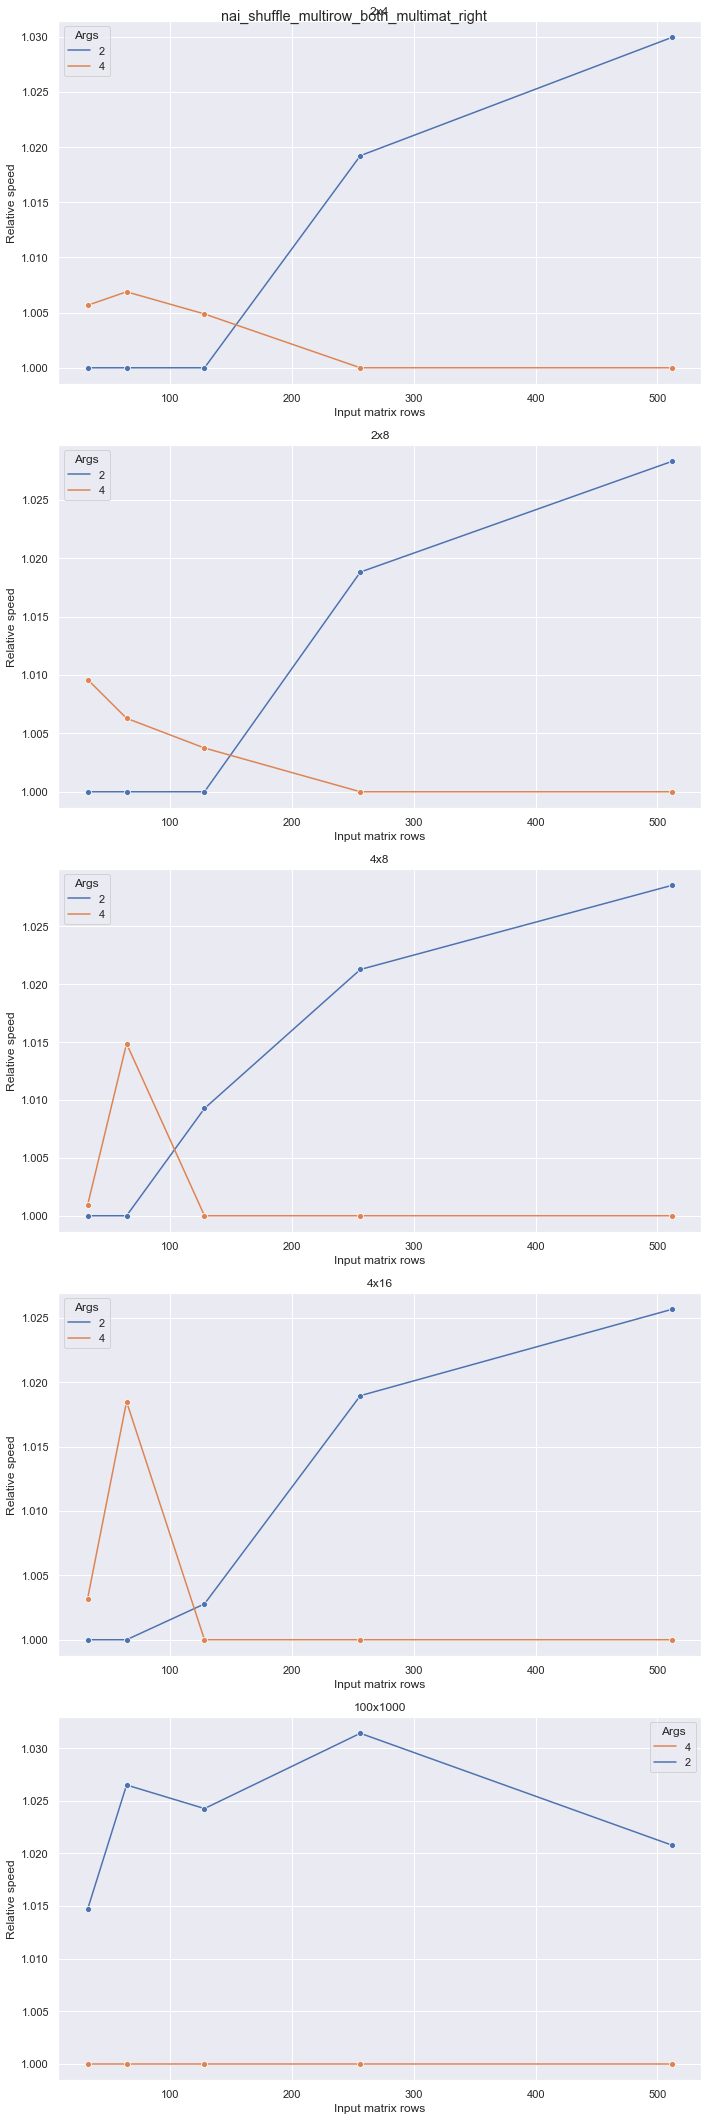

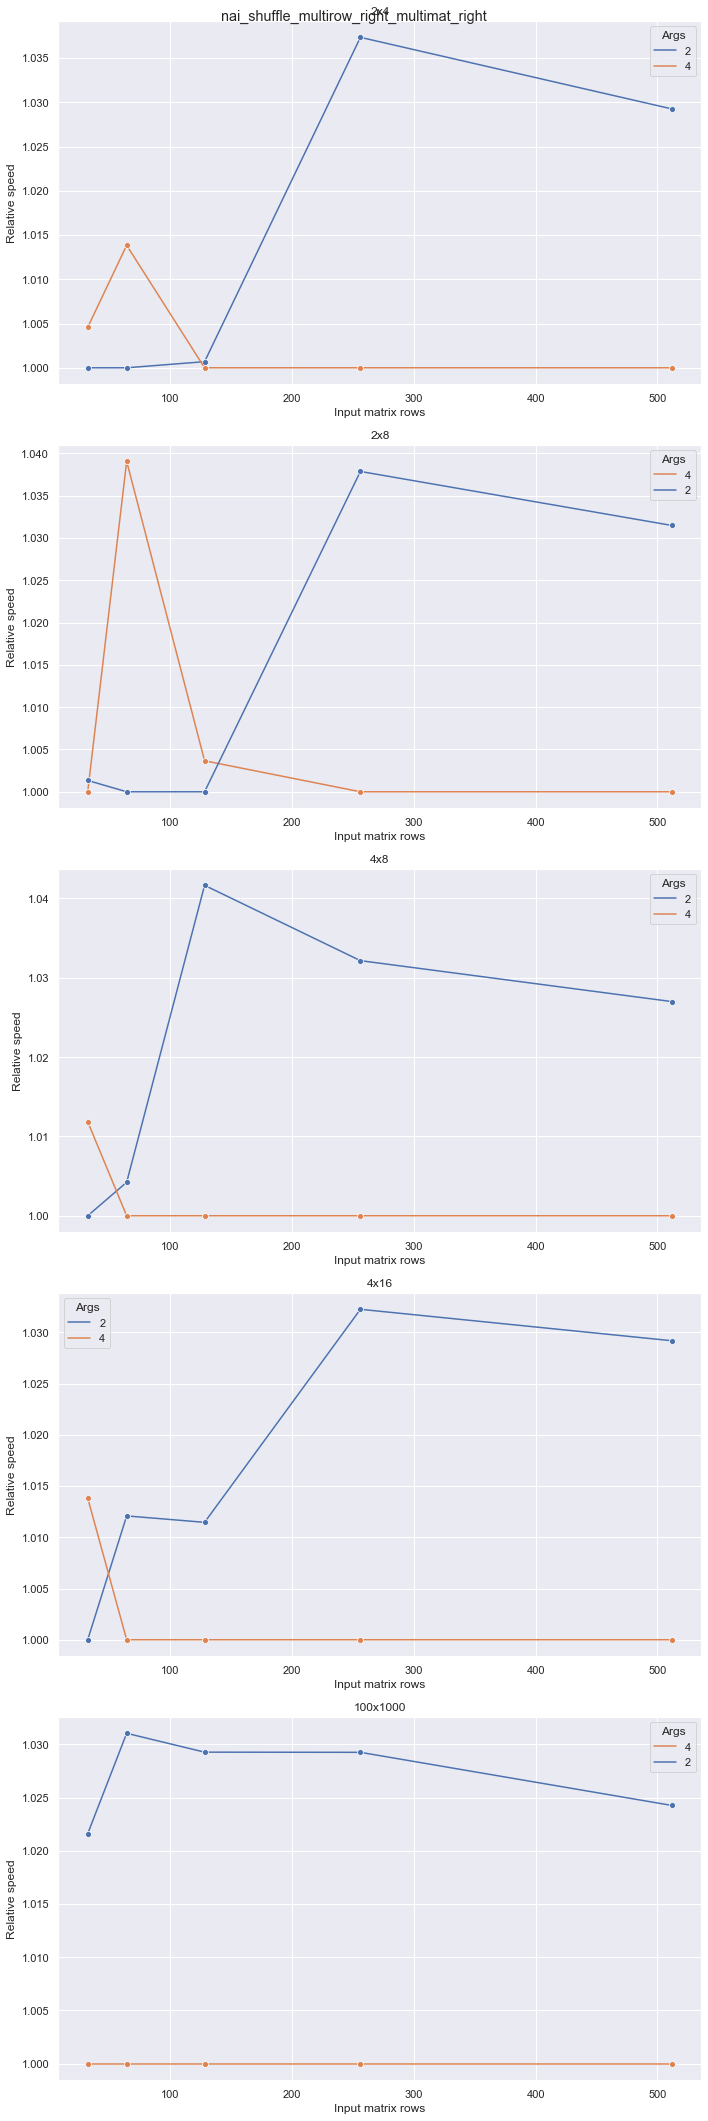

In [12]:
group = benchmark.groups["n_to_mn"]

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

num_input_types = data["Input type"].nunique()

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index().sort_values("Kernel time")

min_times = results.groupby(["Name", "Input left matrices", "Input right matrices", "Input matrix rows"])["Kernel time"].min().to_frame("Kernel time").reset_index()

def speedup(row):
    min_time = min_times[(min_times["Name"] == row["Name"]) & (min_times["Input matrix rows"] == row["Input matrix rows"]) & (min_times["Input right matrices"] == row["Input right matrices"]) & (min_times["Input left matrices"] == row["Input left matrices"])]["Kernel time"].item()
    return row["Kernel time"] / min_time

results["Relative speed"] = results.apply(speedup, axis=1)


sns.set(rc={'figure.figsize': (10, 30)})


for name in sorted(results["Name"].unique()):
    alg_results = results[results["Name"] == name]
    fig, axs = plt.subplots(nrows=num_input_types)

    palette = dict(zip(alg_results["Args"].unique(), sns.color_palette(n_colors=alg_results["Args"].nunique())))

    input_type = 0
    for num_lefts in sorted(alg_results["Input left matrices"].unique()):
        left_results = alg_results[alg_results["Input left matrices"] == num_lefts]
        for num_rights in sorted(left_results["Input right matrices"].unique()):
            right_results = left_results[left_results["Input right matrices"] == num_rights]
            ax = sns.lineplot(data=right_results, x="Input matrix rows", y="Relative speed", hue="Args", marker='o',
                              ax=axs[input_type], palette=palette)
            input_type += 1

            ax.set_title(f"{num_lefts}x{num_rights}")
    fig.suptitle(f"{name}")
    fig.tight_layout()

best_args = results.groupby(["Name", "Args"])["Relative speed"].sum().to_frame("Total relative time").reset_index().sort_values("Total relative time")
print(best_args.groupby(["Name"]).head(3).sort_values("Name", kind="stable"))

# N TO M

                                            Name        Args  \
3    nai_shuffle_multimat_both_work_distribution  4_triangle   
1    nai_shuffle_multimat_both_work_distribution  2_triangle   
0    nai_shuffle_multimat_both_work_distribution      2_none   
7   nai_shuffle_multimat_right_work_distribution  4_triangle   
5   nai_shuffle_multimat_right_work_distribution  2_triangle   
6   nai_shuffle_multimat_right_work_distribution      4_none   
12       nai_shuffle_multirow_both_multimat_both       4_2_2   
9        nai_shuffle_multirow_both_multimat_both       2_2_4   
13       nai_shuffle_multirow_both_multimat_both       4_2_4   

    Total relative time  
3             21.090071  
1             21.203689  
0             50.730387  
7             20.437049  
5             20.627795  
6             35.496606  
12            28.664275  
9             29.410610  
13            29.487039  


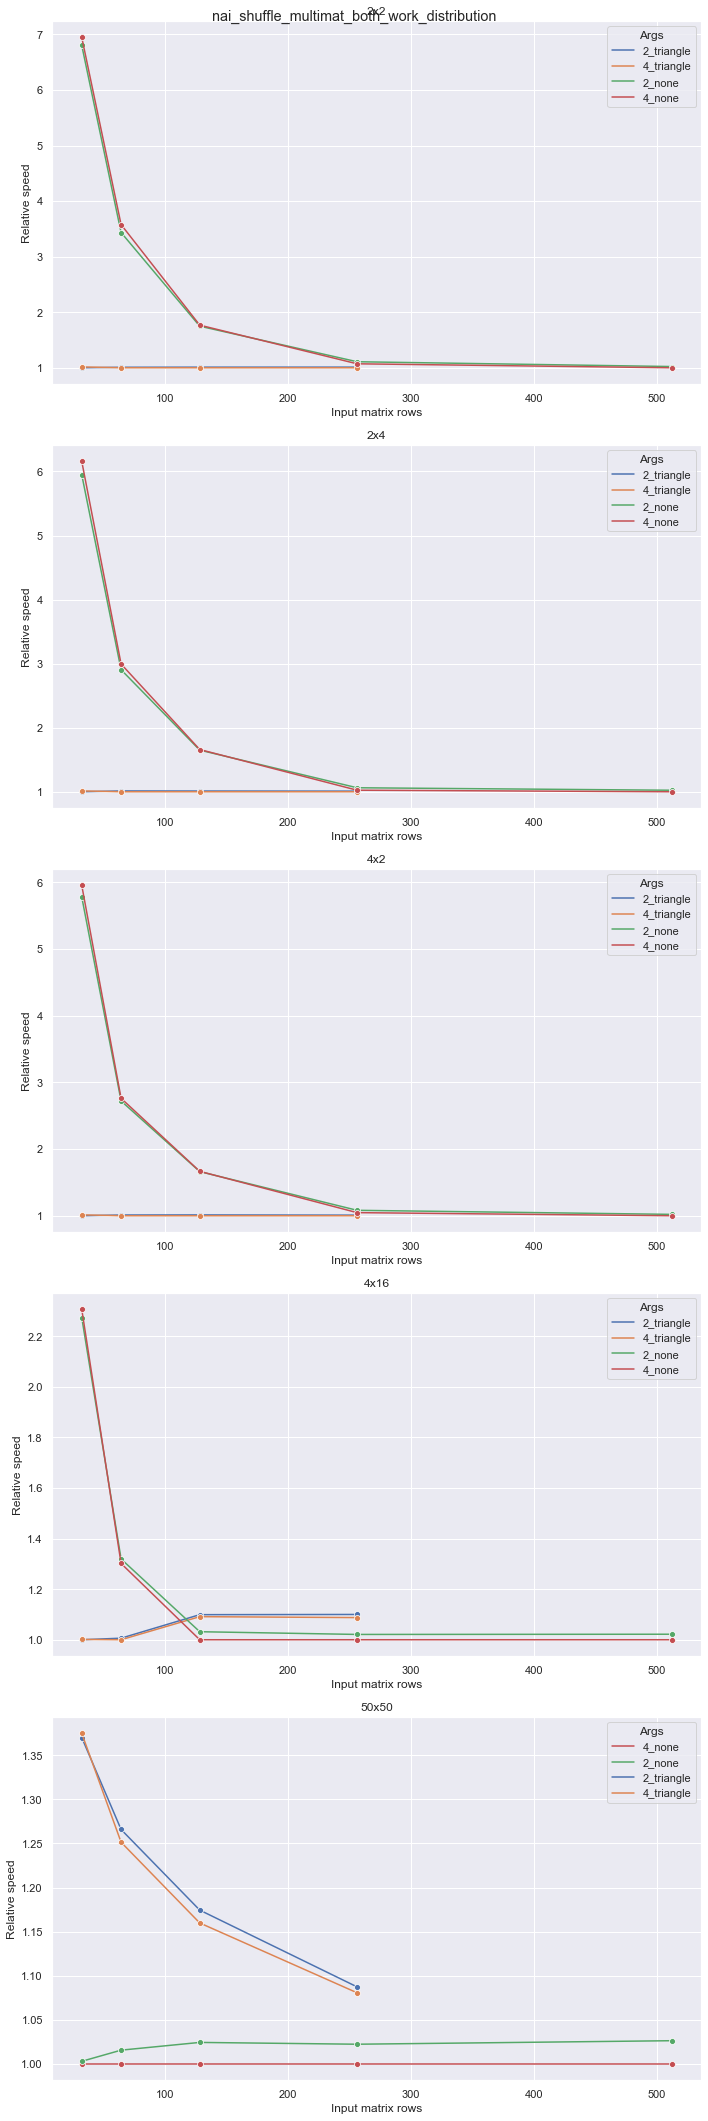

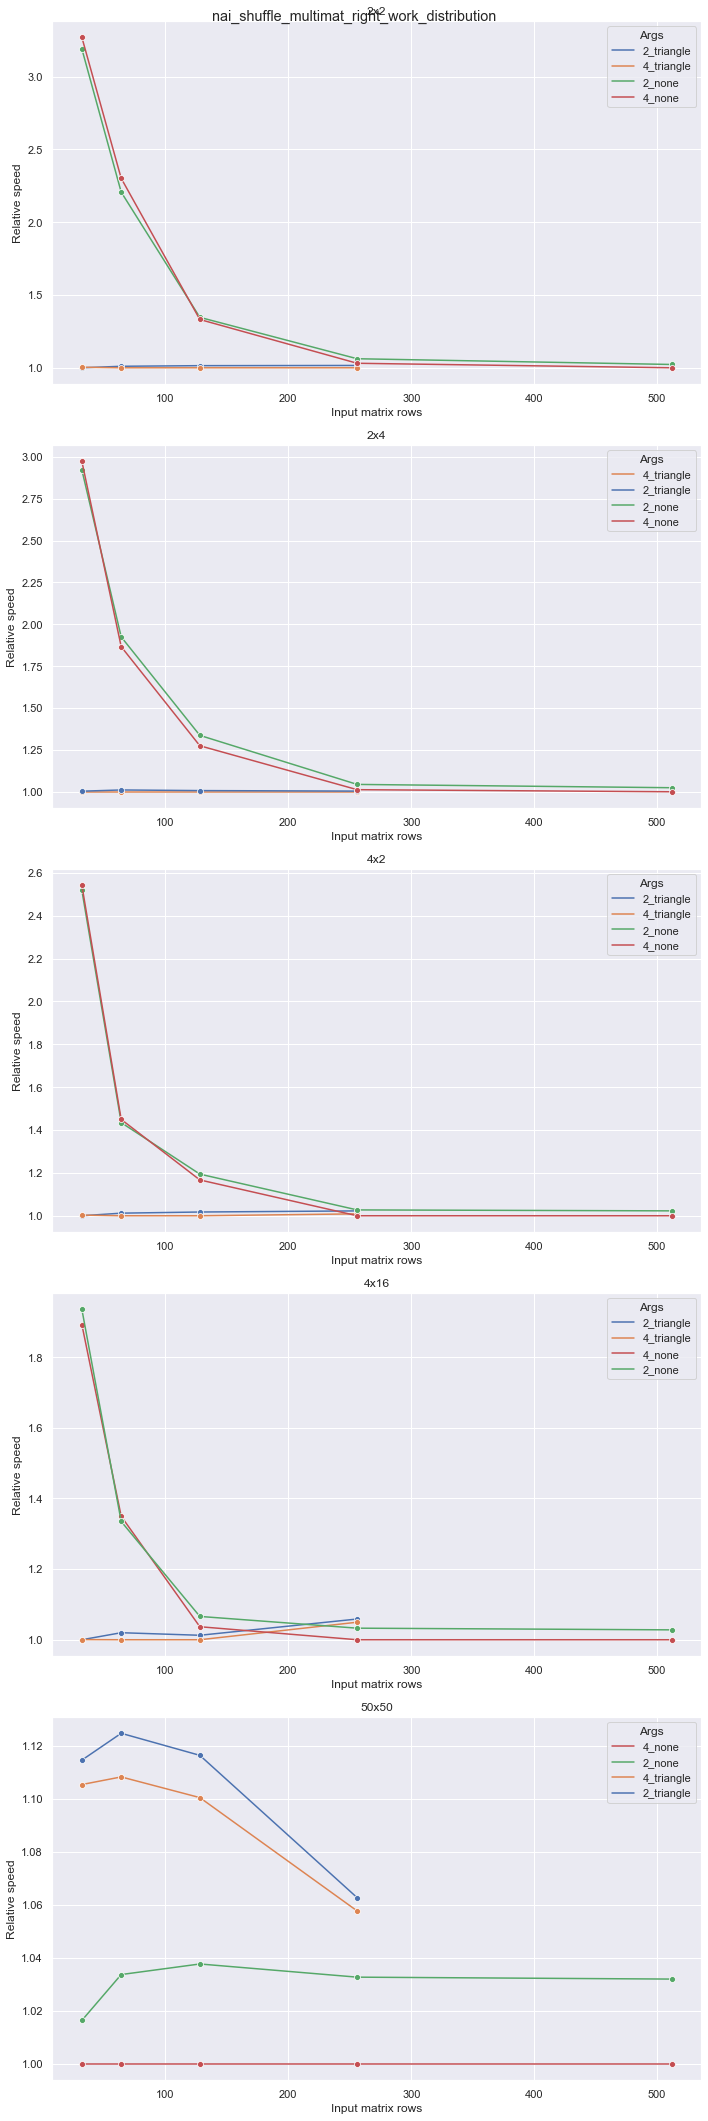

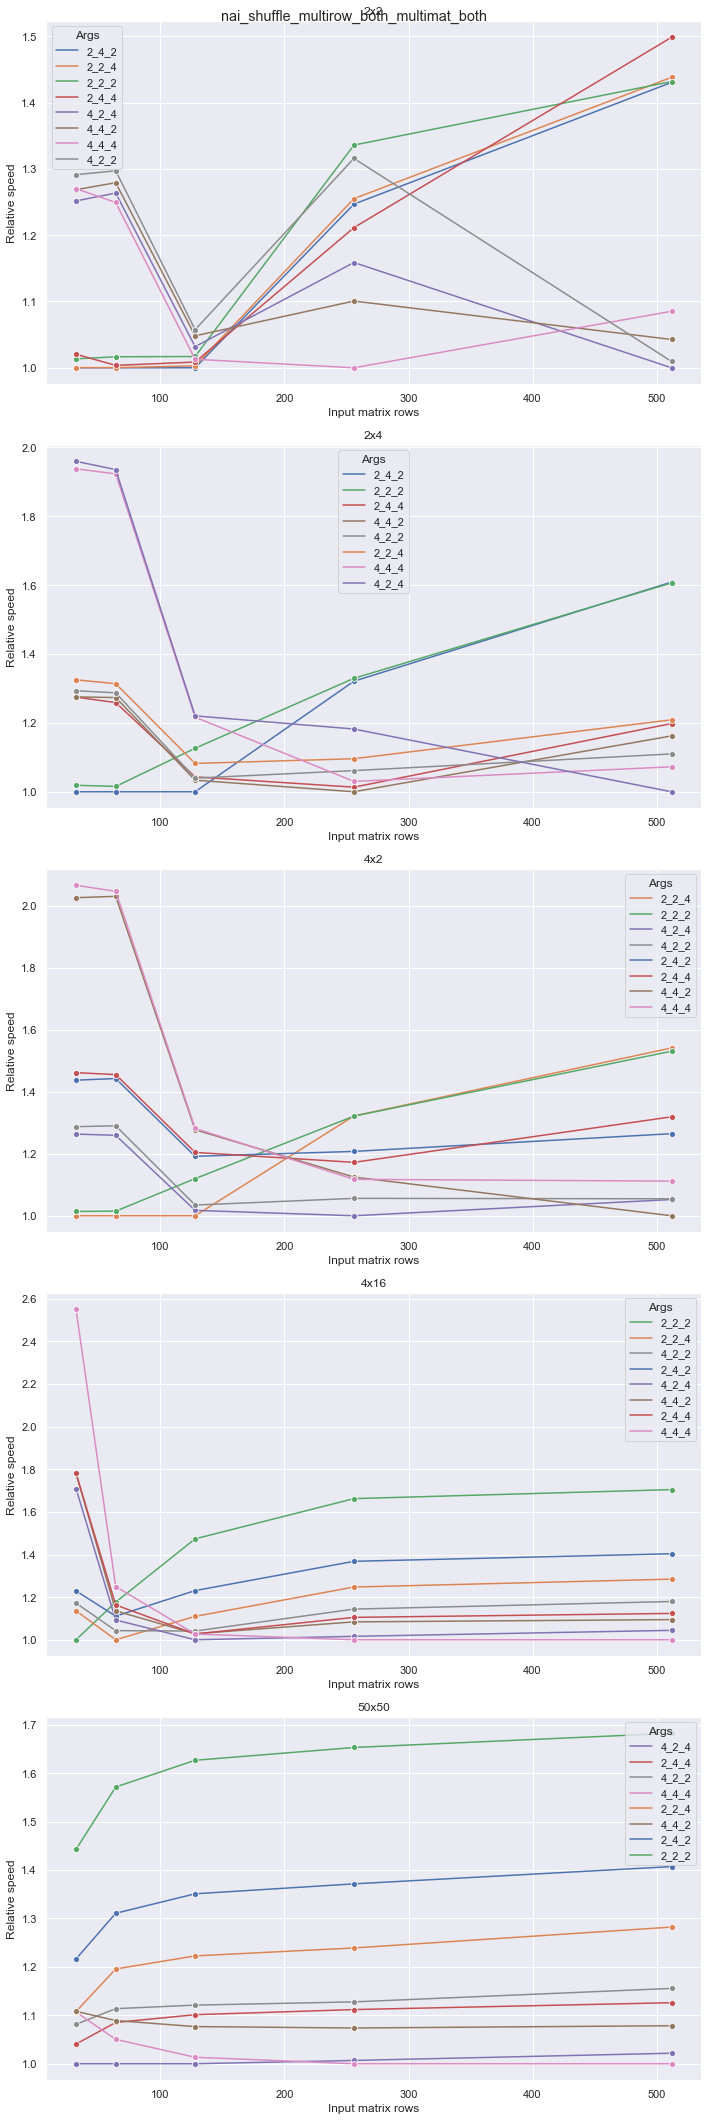

In [13]:
group = benchmark.groups["n_to_m"]

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

num_input_types = data["Input type"].nunique()

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index().sort_values("Kernel time")

min_times = results.groupby(["Name", "Input left matrices", "Input right matrices", "Input matrix rows"])["Kernel time"].min().to_frame("Kernel time").reset_index()

def speedup(row):
    min_time = min_times[(min_times["Name"] == row["Name"]) & (min_times["Input matrix rows"] == row["Input matrix rows"]) & (min_times["Input right matrices"] == row["Input right matrices"]) & (min_times["Input left matrices"] == row["Input left matrices"])]["Kernel time"].item()
    return row["Kernel time"] / min_time

results["Relative speed"] = results.apply(speedup, axis=1)


sns.set(rc={'figure.figsize': (10, 30)})


for name in sorted(results["Name"].unique()):
    alg_results = results[results["Name"] == name]
    fig, axs = plt.subplots(nrows=num_input_types)

    palette = dict(zip(alg_results["Args"].unique(), sns.color_palette(n_colors=alg_results["Args"].nunique())))

    input_type = 0
    for num_lefts in sorted(alg_results["Input left matrices"].unique()):
        left_results = alg_results[alg_results["Input left matrices"] == num_lefts]
        for num_rights in sorted(left_results["Input right matrices"].unique()):
            right_results = left_results[left_results["Input right matrices"] == num_rights]
            ax = sns.lineplot(data=right_results, x="Input matrix rows", y="Relative speed", hue="Args", marker='o',
                              ax=axs[input_type], palette=palette)
            input_type += 1

            ax.set_title(f"{num_lefts}x{num_rights}")
    fig.suptitle(f"{name}")
    fig.tight_layout()

best_args = results.groupby(["Name", "Args"])["Relative speed"].sum().to_frame("Total relative time").reset_index().sort_values("Total relative time")
print(best_args.groupby(["Name"]).head(3).sort_values("Name", kind="stable"))